# Structure Relations


## Setup

### Imports

In [1]:
# Type imports
from typing import Any, Dict, Tuple

# Standard Libraries
from pathlib import Path
from itertools import combinations
from math import sqrt, pi
import re
from statistics import mean
from pprint import pprint

# Shared Packages
import numpy as np
import pandas as pd
import xlwings as xw
import PySimpleGUI as sg
import pydicom
from shapely.geometry import Polygon
from shapely import points
import shapely

import RS_DICOM_Utilities


### Global Settings

In [2]:
PRECISION = 3


## File Paths

In [3]:
base_path = Path.cwd()
data_path = base_path / 'Test Data'
dicom_path = data_path / 'StructureVolumeTests' / 'GJS_Struct_Tests'

- RS.GJS_Struct_Tests.SkippedSlices_A.dcm
- RS.GJS_Struct_Tests.SkippedSlices_B.dcm
- RS.GJS_Struct_Tests.SkippedSlices_C.dcm



In [4]:
skipped_slices_a = dicom_path / 'RS.GJS_Struct_Tests.SkippedSlices_A.dcm'
structure_set_info = RS_DICOM_Utilities.get_structure_file_info(skipped_slices_a)
structure_set_info

{'PatientName': 'StructureVolumes^Test',
 'PatientLastName': 'StructureVolumes',
 'PatientID': 'GJS_Struct_Tests',
 'StructureSet': 'SkippedSlices_A',
 'StudyID': 'Phantom2',
 'SeriesNumber': '0',
 'File': WindowsPath("d:/OneDrive - Queen's University/Python/Projects/StructureRelations/Test Data/StructureVolumeTests/GJS_Struct_Tests/RS.GJS_Struct_Tests.SkippedSlices_A.dcm")}

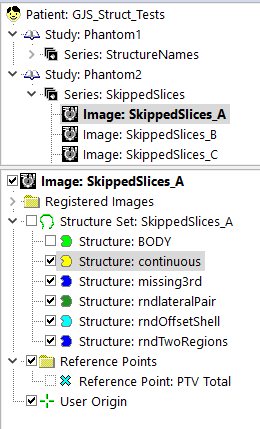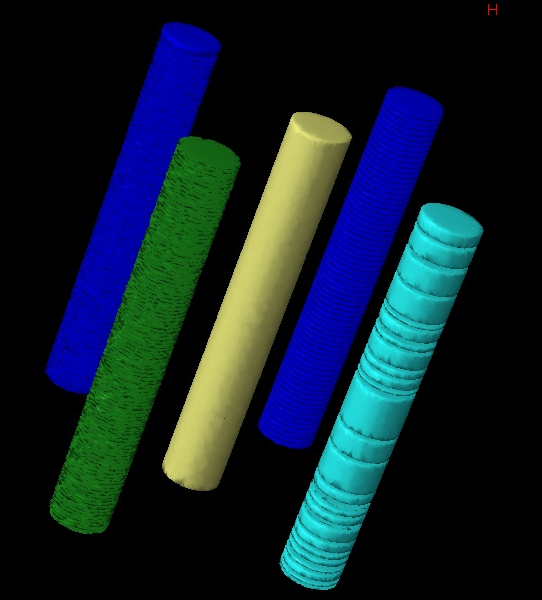

| StructureID    	| ROI # 	| DicomType 	| Volume 	| Equiv. Sphere Diam. 	|
|----------------	|-------	|-----------	|--------	|---------------------	|
| BODY           	| 1     	| EXTERNAL  	| 8043   	| 24.9                	|
| continuous     	| 2     	| NONE      	| 140.7  	| 6.5                 	|
| missing3rd     	| 5     	| NONE      	| 76.1   	| 5.3                 	|
| rndOffsetShell 	| 6     	| NONE      	| 111.7  	| 6                   	|
| rndTwoRegions  	| 4     	| NONE      	| 31.4   	| 3.9                 	|
| rndlateralPair 	| 3     	| NONE      	| 43.7   	| 4.4                 	|

***Volume A***
- Structure with continuous contours
- Structure with every other slice contoured
- Structure with every third slice contoured
- Structure with every third slice missing
- Structure with random missing slices.

## Identify gaps to be filled


- Distinguish between structures with missing slices and multi-region structures
  1. intersection between projection of centre-of-mass of contour from neighbouring slice onto contour in current slice
     - If no overlap, do not interpolate
     - This is also important where there is more than one contour per slice. 
  3. Multiple Gaps
     - If a single gap, do not interpolate
     - _Should a single gap be skipped even if only a single slice is skipped?_
  4. Single slice skipped between contours
     - _Should single slice be skipped even if there is only one gap?_
  5. Distance between slices with contours > limit set for structure (or structure type)
     - @2.5 mm / slice -> 4 slices per cm _Is > 1cm appropriate?_
     - Limit should be larger for OARS than for targets




### Relevant Info
#### Contour Stats

In [5]:
dataset = pydicom.dcmread(structure_set_info['File'])
name_lookup = RS_DICOM_Utilities.get_names_nums(dataset)

contour_sets = RS_DICOM_Utilities.read_contours(dataset)
contour_stats = pd.DataFrame(cntr.info for cntr in contour_sets.values())
contour_stats

,ROI Num,StructureID,Sup Slice,Inf Slice,Length,Thickness,Volume,Eq Sp Diam,Center of Mass,Resolution,Colour
0,1,BODY,10.0,-10.0,20.0,0.100,8019.694,24.834,"(0.0, 0.0, -0.0)",8.525,"(0, 255, 0)"
1,2,continuous,9.9,-9.9,19.8,0.099,140.613,6.452,"(0.015, -0.07, -0.005)",10.726,"(255, 255, 0)"
2,5,missing3rd,9.9,-9.9,19.8,0.149,140.693,6.452,"(5.599, 6.445, -0.031)",10.928,"(0, 0, 255)"
3,6,rndOffsetShell,9.9,-9.9,19.8,0.118,140.913,6.456,"(5.659, -6.466, 0.286)",10.942,"(0, 255, 255)"
4,9,rndMissing,9.9,-9.9,19.8,0.118,140.913,6.456,"(5.659, -6.466, 0.286)",10.942,"(0, 255, 255)"
5,8,every3rd,9.9,-9.9,19.8,0.287,142.157,6.476,"(-5.978, 6.585, 0.279)",10.875,"(255, 0, 255)"
6,7,every2nd,9.9,-9.9,19.8,0.198,141.577,6.466,"(-5.907, -6.427, 0.003)",10.741,"(30, 150, 30)"


#### ROI Number Lookup

In [6]:
roi_lookup = {cntr.structure_id: cntr.roi_num
              for cntr in contour_sets.values()}
roi_lookup

{'BODY': '1',
 'continuous': '2',
 'missing3rd': '5',
 'rndOffsetShell': '6',
 'rndMissing': '9',
 'every3rd': '8',
 'every2nd': '7'}

### Build matrix of structures and the slices with contours
- Index is the slice position of all slices in the image set
- Columns are structure IDs
- Values are the distance (INF) to the next contour

#### Find distance between slices with contours

In [7]:
def slice_spacing(contour):
    inf = contour.dropna().index.min()
    sup = contour.dropna().index.max()
    contour_range = (contour.index <= sup) & (contour.index >= inf)
    slices = contour.loc[contour_range].dropna().index.to_series()
    gaps = slices.shift(-1) - slices
    return gaps


In [8]:
def build_slice_table(contour_sets)->pd.DataFrame:
    def form_table(slice_index):
        slice_index.reset_index(inplace=True)
        slice_index.sort_values('Slice', inplace=True)
        slice_index.set_index(['Slice','StructureID'], inplace=True)
        slice_table = slice_index.unstack()
        slice_table.columns = slice_table.columns.droplevel()
        return slice_table

    slice_index = RS_DICOM_Utilities.build_contour_index(contour_sets)
    slice_table = form_table(slice_index)
    contour_slices = slice_table.apply(slice_spacing)
    return contour_slices

In [10]:
contour_slices = build_slice_table(contour_sets)
#xw.view(contour_slices)
#xw.view(contour_slices.describe())
contour_slices

StructureID,BODY,continuous,every2nd,every3rd,missing3rd,rndMissing,rndOffsetShell
Slice,,,,,,,
-10.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN
-9.9,0.1,0.1,0.2,0.3,0.1,0.2,0.2
-9.8,0.1,0.1,NaN,NaN,0.2,NaN,NaN
-9.7,0.1,0.1,0.2,NaN,NaN,0.1,0.1
-9.6,0.1,0.1,NaN,0.3,0.1,0.2,0.2
...,...,...,...,...,...,...,...
9.6,0.1,0.1,NaN,0.1,0.1,0.1,0.1
9.7,0.1,0.1,0.2,0.1,0.2,0.1,0.1
9.8,0.1,0.1,NaN,0.1,NaN,0.1,0.1


In [11]:
contour_slices.describe()

StructureID,BODY,continuous,every2nd,every3rd,missing3rd,rndMissing,rndOffsetShell
count,2.000000e+02,1.980000e+02,9.900000e+01,68.000000,132.00000,167.000000,167.000000
mean,1.000000e-01,1.000000e-01,2.000000e-01,0.291176,0.15000,0.118563,0.118563
std,4.304374e-16,4.310866e-16,4.552253e-16,0.041377,0.05019,0.046078,0.046078
min,1.000000e-01,1.000000e-01,2.000000e-01,0.100000,0.10000,0.100000,0.100000
25%,1.000000e-01,1.000000e-01,2.000000e-01,0.300000,0.10000,0.100000,0.100000
50%,1.000000e-01,1.000000e-01,2.000000e-01,0.300000,0.15000,0.100000,0.100000
75%,1.000000e-01,1.000000e-01,2.000000e-01,0.300000,0.20000,0.100000,0.100000
max,1.000000e-01,1.000000e-01,2.000000e-01,0.300000,0.20000,0.300000,0.300000


### Identify contours with gaps

In [12]:
def has_gaps(structure_id, contour_slices) -> bool:
    inf = contour_slices[structure_id].dropna().index.min()
    sup = contour_slices[structure_id].dropna().index.max()

    contour_range = (contour_slices.index <= sup) & (contour_slices.index >= inf)
    missing_slices = contour_slices.loc[contour_range, structure_id].isna()
    return any(missing_slices)

In [13]:
has_gaps('missing3rd', contour_slices)

True

In [14]:
has_gaps('continuous', contour_slices)

False

# Identify boundary slices

### Identify nearest slices to missing slices

In [15]:
def neighbouring_slice(slice_index, missing_slices, shift_direction=1,
                       shift_start=0):
    ref = slice_index[missing_slices]
    ref_missing = list(missing_slices)
    shift_size = shift_start
    while ref_missing:
        shift_size += shift_direction
        shift_slice = slice_index.shift(shift_size)[missing_slices]
        ref_idx = ref.isin(ref_missing)
        ref[ref_idx] = shift_slice[ref_idx]
        ref_missing = list(set(ref) & set(missing_slices))
        ref_missing.sort()

    return ref

In [16]:
def next_slice(slice_index, missing_slices, previous,
               direction=1, shift_size=1):
    ref = neighbouring_slice(slice_index, missing_slices,
                             shift_direction=direction, shift_start=shift_size)
    used = (previous == ref)

    while any(used):
        shift_size += direction
        next_shift = neighbouring_slice(slice_index, missing_slices,
                                        shift_direction=direction,
                                        shift_start=shift_size)
        ref[used] = next_shift[used]
        used = (previous == ref)
    return ref


In [17]:
def find_neighbouring_slice(slice_index, missing_slices):
    inf1 = neighbouring_slice(slice_index, missing_slices, shift_direction=-1)
    inf2 = next_slice(slice_index, missing_slices, inf1, direction=-1,
                    shift_size=-1)
    sup1 = neighbouring_slice(slice_index, missing_slices, shift_direction=1)
    sup2 = next_slice(slice_index, missing_slices, sup1, direction=1,
                    shift_size=1)

    ref = pd.concat([inf1, inf2, sup1, sup2], axis='columns')
    ref.columns = ['inf1', 'inf2', 'sup1', 'sup2']
    return ref


In [18]:
structure_id = 'every3rd'

inf = contour_slices[structure_id].dropna().index.min()
sup = contour_slices[structure_id].dropna().index.max()

contour_range = (contour_slices.index <= sup) & (contour_slices.index >= inf)
structure_slices = contour_slices.loc[contour_range, structure_id]
slice_index = structure_slices.index.to_series()
missing_slices = slice_index[structure_slices.isna()]


In [19]:
ref = find_neighbouring_slice(slice_index, missing_slices)
#xw.view(ref)

In [20]:
neighbours = ref.T[-9.2]
neighbours

inf1   -9.0
inf2   -8.7
sup1   -9.3
sup2   -9.6
Name: -9.2, dtype: float64

In [21]:
roi = roi_lookup[structure_id]
contour_sets[roi].info

{'ROI Num': '8',
 'StructureID': 'every3rd',
 'Sup Slice': 9.9,
 'Inf Slice': -9.9,
 'Length': 19.8,
 'Thickness': 0.287,
 'Volume': 142.157,
 'Eq Sp Diam': 6.476,
 'Center of Mass': (-5.978, 6.585, 0.279),
 'Resolution': 'Normal',
 'Colour': ('255', '0', '255')}

In [22]:
contour_sets[roi].contours[neighbours.inf1]

Single Solid ContourSlice, at slice -9.0, containing Polygon

In [23]:
a = contour_sets[roi].contours[neighbours.inf1].contour
b = contour_sets[roi].contours[neighbours.sup1].contour
a.intersects(b)

True

In [24]:
a = shapely.set_precision(a, 0.01)
b = shapely.set_precision(b, 0.01)

In [25]:
shapely.intersects(a,b)

True

In [26]:
inf1 = shapely.get_coordinates(a, include_z=True)
sup1 = shapely.get_coordinates(b, include_z=True)

In [27]:
type(inf1)

numpy.ndarray

In [28]:
from scipy.interpolate import interpn

In [29]:
sup1

array([[-7.44,  6.94, -9.3 ],
       [-7.42,  6.97, -9.3 ],
       [-7.4 ,  7.09, -9.3 ],
       [-7.37,  7.21, -9.3 ],
       [-7.32,  7.27, -9.3 ],
       [-7.28,  7.32, -9.3 ],
       [-7.23,  7.44, -9.3 ],
       [-7.21,  7.47, -9.3 ],
       [-7.13,  7.56, -9.3 ],
       [-7.09,  7.61, -9.3 ],
       [-7.02,  7.68, -9.3 ],
       [-6.97,  7.72, -9.3 ],
       [-6.9 ,  7.79, -9.3 ],
       [-6.85,  7.83, -9.3 ],
       [-6.74,  7.88, -9.3 ],
       [-6.7 ,  7.91, -9.3 ],
       [-6.62,  7.98, -9.3 ],
       [-6.5 ,  7.99, -9.3 ],
       [-6.44,  8.03, -9.3 ],
       [-6.39,  8.06, -9.3 ],
       [-6.27,  8.07, -9.3 ],
       [-6.15,  8.1 , -9.3 ],
       [-6.03,  8.11, -9.3 ],
       [-5.92,  8.1 , -9.3 ],
       [-5.8 ,  8.1 , -9.3 ],
       [-5.68,  8.07, -9.3 ],
       [-5.57,  8.06, -9.3 ],
       [-5.51,  8.03, -9.3 ],
       [-5.45,  7.99, -9.3 ],
       [-5.33,  7.98, -9.3 ],
       [-5.24,  7.91, -9.3 ],
       [-5.21,  7.89, -9.3 ],
       [-5.1 ,  7.82, -9.3 ],
       [-5

# Done to Here


## Routine to match multiple polygons in a contour slice with polygons in the next slice
- Measure overlap area 
- Identify some overlap
- Identify most overlap

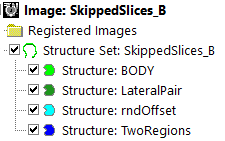

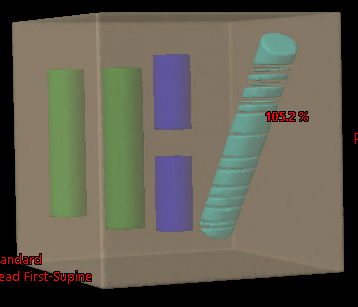


In [100]:
skipped_slices_a = dicom_path / 'RS.GJS_Struct_Tests.SkippedSlices_B.dcm'
structure_set_info = RS_DICOM_Utilities.get_structure_file_info(skipped_slices_a)
structure_set_info

{'PatientName': 'StructureVolumes^Test',
 'PatientLastName': 'StructureVolumes',
 'PatientID': 'GJS_Struct_Tests',
 'StructureSet': 'SkippedSlices_B',
 'StudyID': 'Phantom2',
 'SeriesNumber': '3',
 'File': WindowsPath("d:/OneDrive - Queen's University/Python/Projects/StructureRelations/Test Data/StructureVolumeTests/GJS_Struct_Tests/RS.GJS_Struct_Tests.SkippedSlices_B.dcm")}

In [68]:
dataset = pydicom.dcmread(structure_set_info['File'])
name_lookup = RS_DICOM_Utilities.get_names_nums(dataset)

contour_sets = RS_DICOM_Utilities.read_contours(dataset)
contour_stats = pd.DataFrame(cntr.info for cntr in contour_sets.values())


In [44]:
roi_lookup = {cntr.structure_id: cntr.roi_num
              for cntr in contour_sets.values()}
roi_lookup

{'BODY': '1', 'LateralPair': '9', 'rndOffset': '8', 'TwoRegions': '7'}

In [51]:
contour_slices = build_slice_table(contour_sets)
#xw.view(contour_slices)
#xw.view(contour_slices.describe())


In [69]:
structure_id = 'LateralPair'
slice_num = roi_lookup[structure_id]

inf = contour_slices[structure_id].dropna().index.min()
sup = contour_slices[structure_id].dropna().index.max()

contour_range = (contour_slices.index <= sup) & (contour_slices.index >= inf)
structure_slices = contour_slices.loc[contour_range, structure_id]
slice_index = structure_slices.index.to_series()
missing_slices = slice_index[structure_slices.isna()]
contoured_slices = structure_slices.dropna()

In [70]:
contoured_slices = structure_slices.dropna().index.to_series()

In [71]:
slice_index = list(contoured_slices)


In [72]:
slice1 = contour_sets[slice_num].contours[slice_index[1]]
slice2 = contour_sets[slice_num].contours[slice_index[2]]

In [73]:
slice1

Multi Solid ContourSlice, at slice -5.9, containing MultiPolygon

In [74]:
slice2

Multi Solid ContourSlice, at slice -5.8, containing MultiPolygon

In [75]:
slice1.region_count

2

In [76]:
slice2.region_count

2

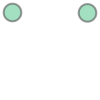

In [79]:
slice1.contour

## Measure overlap area 

In [89]:
match = {}
for idx1, poly1 in enumerate(slice1.contour.geoms):
    sub_match = {}
    for idx2, poly2 in enumerate(slice2.contour.geoms):
        area = shapely.intersection(poly1, poly2).area
        sub_match[idx2] = area
    match[idx1] = sub_match
pd.DataFrame(match)

,0,1
0,7.077366,0.000000
1,0.000000,7.071776


In [106]:
pd.DataFrame(match).stack()

0  0    7.077366
   1    0.000000
1  0    0.000000
   1    7.071776
dtype: float64

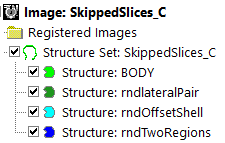
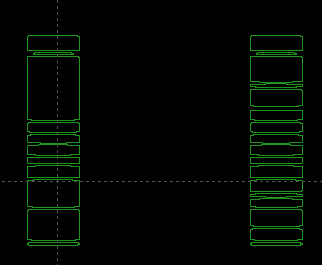
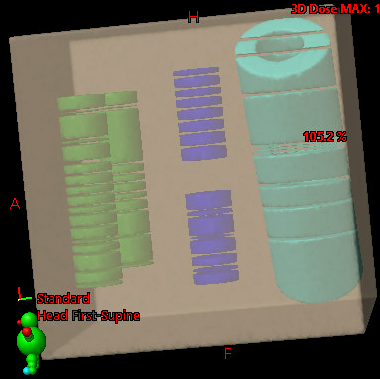

In [101]:
skipped_slices_c = dicom_path / 'RS.GJS_Struct_Tests.SkippedSlices_C.dcm'
structure_set_info = RS_DICOM_Utilities.get_structure_file_info(skipped_slices_c)
structure_set_info

{'PatientName': 'StructureVolumes^Test',
 'PatientLastName': 'StructureVolumes',
 'PatientID': 'GJS_Struct_Tests',
 'StructureSet': 'SkippedSlices_C',
 'StudyID': 'Phantom2',
 'SeriesNumber': '0',
 'File': WindowsPath("d:/OneDrive - Queen's University/Python/Projects/StructureRelations/Test Data/StructureVolumeTests/GJS_Struct_Tests/RS.GJS_Struct_Tests.SkippedSlices_C.dcm")}

In [102]:
dataset = pydicom.dcmread(structure_set_info['File'])
name_lookup = RS_DICOM_Utilities.get_names_nums(dataset)

contour_sets = RS_DICOM_Utilities.read_contours(dataset)
contour_stats = pd.DataFrame(cntr.info for cntr in contour_sets.values())


In [103]:
roi_lookup = {cntr.structure_id: cntr.roi_num
              for cntr in contour_sets.values()}
roi_lookup

{'rndOffsetShell': '6',
 'rndTwoRegions': '4',
 'rndlateralPair': '3',
 'BODY': '1'}

In [99]:
contour_slices = build_slice_table(contour_sets)
#xw.view(contour_slices)
#xw.view(contour_slices.describe())


In [104]:
structure_id = 'rndlateralPair'
slice_num = roi_lookup[structure_id]

inf = contour_slices[structure_id].dropna().index.min()
sup = contour_slices[structure_id].dropna().index.max()

contour_range = (contour_slices.index <= sup) & (contour_slices.index >= inf)
structure_slices = contour_slices.loc[contour_range, structure_id]
slice_index = structure_slices.index.to_series()
missing_slices = slice_index[structure_slices.isna()]
contoured_slices = structure_slices.dropna()

# Look for Projection overlap
intersection between projection of centre-of-mass of contour from neighbouring slice onto contour in current slice
- If no overlap, do not interpolate
- This is also important where there is more than one contour per slice. 
- Need to to this separately for each contour polygon in the slice

**Overlaps ignores _Z_ component of contour**


In [ ]:
a = contour_sets[roi_lookup['continuous']].contours[-9.9].contour
b = contour_sets[roi_lookup['continuous']].contours[-9.8].contour
a.overlaps(b)

In [ ]:
c = contour_sets[roi_lookup['missing3rd']].contours[-9.9].contour
a.overlaps(c)

In [ ]:
structure_id = 'missing3rd'

inf = contour_slices[structure_id].dropna().index.min()
sup = contour_slices[structure_id].dropna().index.max()

contour_range = (contour_slices.index <= sup) & (contour_slices.index >= inf)
structure_slices = contour_slices.loc[contour_range, structure_id]
missing_slices = structure_slices.isna()


In [ ]:
structure_id = 'rndOffsetShell'

inf = contour_slices[structure_id].dropna().index.min()
sup = contour_slices[structure_id].dropna().index.max()

contour_range = (contour_slices.index <= sup) & (contour_slices.index >= inf)
structure_slices = contour_slices.loc[contour_range, structure_id]
missing_slices = structure_slices.isna()


In [ ]:
roi = roi_lookup[structure_id]
roi

# Metrics

In [ ]:
contour_sets[2].contours[0].contour.distance(contour_sets[3].contours[0].contour)

In [ ]:
contour_sets[3].contours[0].contour.distance(contour_sets[13].contours[0].contour)

In [ ]:
contour_sets[13].contours[0].contour.bounds

In [ ]:
contour_sets[3].contours[0].contour.bounds

`bounds(geometry, **kwargs)`
Computes the bounds (extent) of a geometry.

For each geometry these 4 numbers are returned: 
> (min x, min y, max x, max y)

In [ ]:
contour_sets[2].contours[0].contour.bounds

In [ ]:
contour = contour_sets[2].contours[0].contour.bounds

In [ ]:
slices = contour_sets[3].contours[0].contour.bounds


In [ ]:
[(contour[0], contour[1]), (contour[2], contour[3]), (contour[0], contour[3]), (contour[2], contour[1])]

**shapely.prepare**

`prepare(geometry, **kwargs)`
> Prepare a geometry, improving performance of other operations.
>
> A prepared geometry is a normal geometry with added information such as an index on the line segments. This improves the performance of the following operations: contains, contains_properly, covered_by, covers, crosses, disjoint, intersects, overlaps, touches, and within.
>
> Note that if a prepared geometry is modified, the newly created Geometry object is not prepared. In that case, prepare should be called again.
>
> This function does not recompute previously prepared geometries; it is efficient to call this function on an array that partially contains prepared geometries.
>
> This function does not return any values; geometries are modified in place.


**shapely.set_precision**

`set_precision(geometry, grid_size, mode='valid_output', **kwargs)`

> Returns geometry with the precision set to a precision grid size.
>
> By default, geometries use double precision coordinates (grid_size = 0).
> 
> Coordinates will be rounded if a precision grid is less precise than the input geometry. Duplicated vertices will be dropped from lines and polygons for grid sizes greater than 0. Line and polygon geometries may collapse to empty geometries if all vertices are closer together than grid_size. Z values, if present, will not be modified.
> 
> **Note:** subsequent operations will always be performed in the precision of the geometry with higher precision (smaller “grid_size”). That same precision will be attached to the operation outputs.
> 
> **Also note:** input geometries should be geometrically valid; unexpected results may occur if input geometries are not.
> 
> *Returns* None if geometry is None.
>
> **Parameters**:
>> **geometry**: Geometry or array_like
>> 
>> **grid_size**: float
>>> Precision grid size. If 0, will use double precision (will not modify geometry if precision grid size was not previously set). If this value is more precise than input geometry, the input geometry will not be modified.
>> 
>> **mode**: {‘valid_output’, ‘pointwise’, ‘keep_collapsed’}, default ‘valid_output’
>>> This parameter determines how to handle invalid output geometries. There are three modes:
>>> *‘valid_output’* (default): The output is always valid. Collapsed geometry elements (including both polygons and lines) are removed. Duplicate vertices are removed.
>>> *‘pointwise’*: Precision reduction is performed pointwise. Output geometry may be invalid due to collapse or self-intersection. Duplicate vertices are not removed. In GEOS this option is called NO_TOPO.
>>> *‘keep_collapsed’*: Like the default mode, except that collapsed linear geometry elements are preserved. Collapsed polygonal input elements are removed. Duplicate vertices are removed.
>> 
>> **kwargs: See NumPy ufunc docs for other keyword arguments.

> **Examples**
```python
from shapely import LineString, Point
set_precision(Point(0.9, 0.9), 1.0)
<POINT (1 1)>
set_precision(Point(0.9, 0.9, 0.9), 1.0)
<POINT Z (1 1 0.9)>
set_precision(LineString([(0, 0), (0, 0.1), (0, 1), (1, 1)]), 1.0)
<LINESTRING (0 0, 0 1, 1 1)>
set_precision(LineString([(0, 0), (0, 0.1), (0.1, 0.1)]), 1.0, mode="valid_output")
<LINESTRING Z EMPTY>
set_precision(LineString([(0, 0), (0, 0.1), (0.1, 0.1)]), 1.0, mode="pointwise")
<LINESTRING (0 0, 0 0, 0 0)>
set_precision(LineString([(0, 0), (0, 0.1), (0.1, 0.1)]), 1.0, mode="keep_collapsed")
<LINESTRING (0 0, 0 0)>
set_precision(None, 1.0) is None
```